# SBU CSE 352 - HW 1.2 - Search: Solving a Maze Using a Goal-based Agent


Name: Cody Lam

I understand that my submission needs to be my own work: yes

---

## Instructions

Total Points: 100

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy, scipy, and built-in packages like random). Submit the completely rendered notebook as a HTML file.


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [1]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/Search
!ls

Cloning into 'CS7320-AI'...
remote: Enumerating objects: 2755, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 2755 (delta 4), reused 0 (delta 0), pack-reused 2740 (from 2)
Receiving objects: 100% (2755/2755), 252.36 MiB | 13.29 MiB/s, done.
Resolving deltas: 100% (1719/1719), done.
/content/CS7320-AI/Search
empty_2_maze.txt	  loops_maze.txt		     maze_helper.py   small_maze.txt
empty_maze.txt		  Maze_BFS_vs_A_Star.ipynb	     Maze.ipynb       wall_maze.txt
Explore_heuristics.ipynb  Maze_Example-Animation_full.ipynb  medium_maze.txt
large_maze.txt		  Maze_Example-Animation.ipynb	     open_maze.txt
L_maze.txt		  Maze_Example.ipynb		     README.md


In [43]:
# if the below fails to open, then small_maze.txt is not in the current working directory (see above code block)
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [44]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

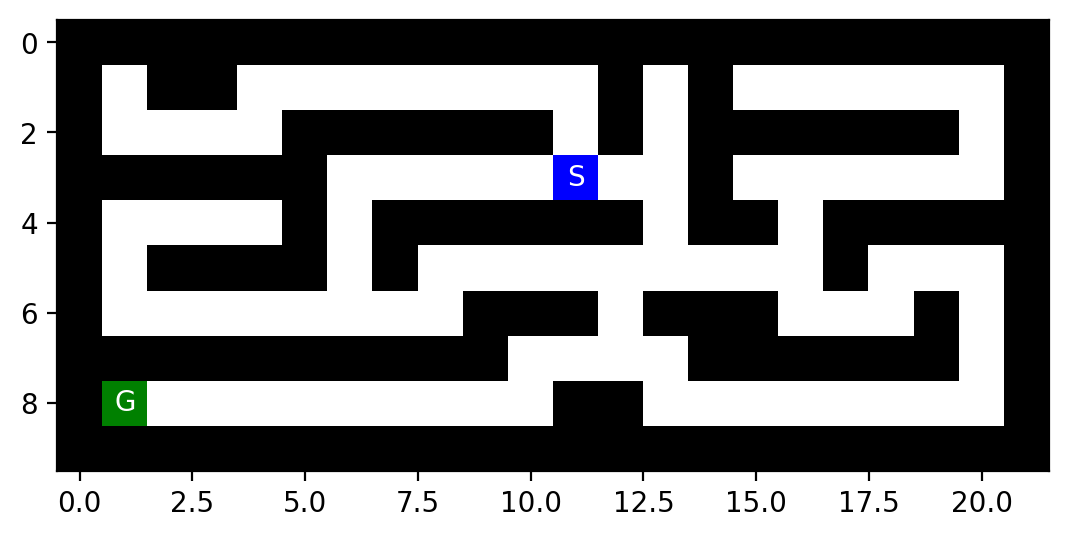

In [45]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

mh.show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [46]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [6]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    /content/CS7320-AI/Search/maze_helper.py




## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [47]:
class Node:
    def __init__(self, pos, parent, action, cost, heuristic):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
        self.heuristic = heuristic # for heurisitic value

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        path = []
        node = self

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

    # This defines priority order for heapq
    def __lt__(self, other):
        return (self.cost + self.heuristic) < (other.cost + other.heuristic)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
2. You notebook needs to be formated professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

In [ ]:
# Your answer goes here
"""
- Initial State: The initial state is going to be the starting position, s, in the maze and it can be represented as a tuple (row, col)
- Actions: The agent can move four possible directions: Up(row - 1, col), Down(row + 1, col), Left(row, col - 1) and Right(row, col + 1) and can only move into empty cells (' '),
  so it doesn't go into walls.
- Transition model: This defines the result of when an action is performed on a state. For example, if the current state is (row, col) and the action move_up was applied to the state,
  the result would be (row - 1, col) if there is no wall in the way.
- Goal state: The goal state is the the goal position, G, which is also represented as a tuple (row, col)
- Path Cost: The Path cost is the number of steps it takes to reach the goal, each move or action is going to have a uniform cost of 1 and the total path cost is going to be the
  depth of the search tree
"""


Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

In [ ]:
# Your answer goes here
"""
- n: The estimation of n is total number of possible states, which is going to be the number of cells and the start and goal. Therefore, count the total number of empty (' ')
  spaces including the S and G spaces
- d: This is going to be determined by finding the minimum number of moves that are required to reach the goal from the start. The estimation of d will depend on the layout of
  the maze, so shorter in open mazes, but longer with mazes with more obstacles. You can run BFS since it guarantees the shortest path.
- m: The maximum depth of the tree is determined by finding the deepest node that the algorithm explored and DFS can be used to determined m. If DFS without cycle detection was used then
  m can be as large as n, if there is cycle detection then m is the maze's dimension and structure.
- b: The maximum branching factor is determined by finding the average number of successors per state. The estimation would be to count the average number of open adjecent cells
  for a random sample of states. An example, would be in an open maze the max branching factor would be 4 since you can go up, down, left, right
"""

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore.
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

Start (3, 11), Goal: (8, 1)


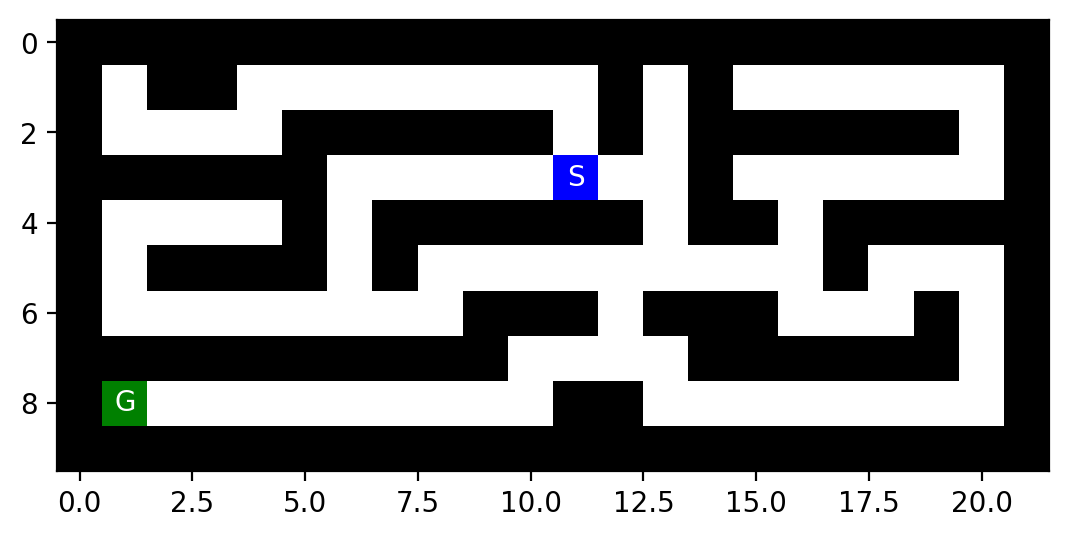

BFS - Path Cost: 19, Nodes Expanded: 92, Max Depth: 19, Max Nodes: 94, Max Frontier Size: 7
DFS - Path Cost: 37, Nodes Expanded: 38, Max Depth: 37, Max Nodes: 43, Max Frontier Size: 6


In [48]:
from collections import deque

# Helper function to return all the possible moves based on the node's position
def get_valid_moves(maze, pos):
  moves = []
  directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
  for direction_row, direction_col in directions:
    new_r, new_c = pos[0] + direction_row, pos[1] + direction_col
    if 0 <= new_r < maze.shape[0] and 0 <= new_c < maze.shape[1]:
      if maze[new_r, new_c] != 'X':
        moves.append((new_r, new_c))
  return moves

# Breadth First Search
def bfs(maze, start, goal):
  frontier = deque([Node(start, parent=None, action=None, cost=0, heuristic=0)])
  reached = {start}
  nodes_expanded = 0
  max_frontier_size = 1
  max_nodes_in_memory = 1
  max_depth = 0

  while frontier:
    node = frontier.popleft()
    nodes_expanded += 1
    max_depth = max(max_depth, node.cost)
    max_frontier_size = max(max_frontier_size, len(frontier))
    max_nodes_in_memory = max(max_nodes_in_memory, len(frontier) + len(reached))

    if node.pos == goal:
        return node.get_path_from_root(), node.cost, nodes_expanded, max_depth, max_nodes_in_memory, max_frontier_size

    for move in get_valid_moves(maze, node.pos):
      if move not in reached:
        reached.add(move)
        frontier.append(Node(move, node, action=move, cost=node.cost + 1, heuristic=0))
  return None, -1, nodes_expanded, max_depth, max_nodes_in_memory, max_frontier_size

# Depth First Search
def dfs(maze, start, goal):
  frontier = [Node(start, parent=None, action=None, cost=0, heuristic=0)]
  explored = set()
  nodes_expanded = 0
  max_frontier_size = 1
  max_depth = 0
  max_nodes_in_memory = 1

  while frontier:
    node = frontier.pop()
    nodes_expanded += 1
    max_depth = max(max_depth, node.cost)
    max_frontier_size = max(max_frontier_size, len(frontier))
    max_nodes_in_memory = max(max_nodes_in_memory, len(frontier) + len(explored))

    if node.pos == goal:
        return node.get_path_from_root(), node.cost, nodes_expanded, max_depth, max_nodes_in_memory, max_frontier_size
    if node.pos not in explored:
      explored.add(node.pos)
      for move in get_valid_moves(maze, node.pos):
        if move not in explored:
          frontier.append(Node(move, parent=node, action=move, cost=node.cost + 1, heuristic=0))
  return None, -1, nodes_expanded, max_depth, max_nodes_in_memory, max_frontier_size

start = mh.find_pos(maze, what = "S")
goal = mh.find_pos(maze, what = "G")
print(f"Start {start}, Goal: {goal}")
mh.show_maze(maze)

bfs_path, bfs_cost, bfs_expanded, bfs_max_depth, bfs_max_nodes, bfs_frontier = bfs(maze, start, goal)
print(f"BFS - Path Cost: {bfs_cost}, Nodes Expanded: {bfs_expanded}, Max Depth: {bfs_max_depth}, Max Nodes: {bfs_max_nodes}, Max Frontier Size: {bfs_frontier}")

dfs_path, dfs_cost, dfs_expanded, dfs_max_depth, dfs_max_nodes, dfs_frontier = dfs(maze, start, goal)
print(f"DFS - Path Cost: {dfs_cost}, Nodes Expanded: {dfs_expanded}, Max Depth: {dfs_max_depth}, Max Nodes: {dfs_max_nodes}, Max Frontier Size: {dfs_frontier}")

How does BFS and DFS deal with loops (cycles)?




In [ ]:
# Discussion
"""
In both DFS and BFS it deals with loops it by using a set, so that there are no duplications on the cells that were already visited or explored. Before expanding to the next node,
it checks if it's already explored so that it will avoid any infinite loops or cycles.
"""

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

In [ ]:
# Discussion
"""
The Breadth First Search is complete because it explores all possible paths level by level until it finds the goal and if a solution exists then BFS will find it.
My implementation is optimal because it finds the shortest path to the goal,and you can see that the path cost is less than the path cost from DFS. It will also always find a solution
even in the presence of loops. The time complexity of the BFS is O(b^d) and the space complexity is O(b ^ d). The implementation for Depth First Search is not optimal because it
will find the solution but it won't find the shortest one. However, DFS is complete only if the search space is finite and cycle checking is implemented which is used in my implementation
because it avoids revisiting nodes so it won't be stuck in infinite loops if cycles exist in the maze. The time complexity of the DFS is O(b^m) and the space complexity is O(bm) with cycling.
"""

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

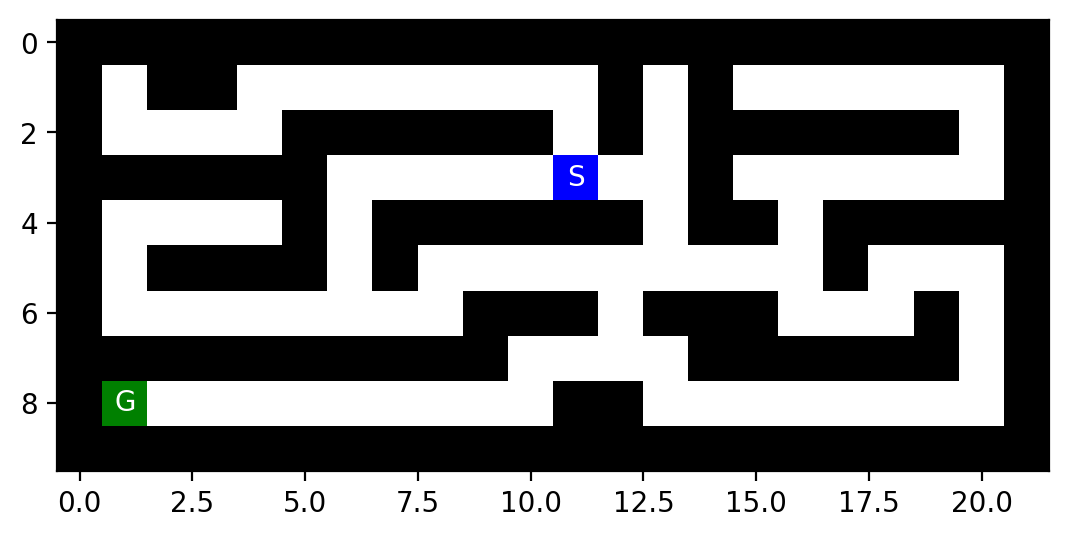

GBFS - Path Cost: 29, Nodes Expanded: 40, Max Depth: 29, Max Nodes: 48, Max Frontier Size: 4
A* - Path Cost: 19, Nodes Expanded: 54, Max Depth: 19, Max Nodes: 65,  Max Frontier Size: 7


In [96]:
# Your code goes here
import heapq

def manhattan_distance(pos, goal):
  return abs(pos[0] - goal[0]) + abs(pos[1] - goal[1])

# Greedy Best-First Search (GBFS)
def gbfs(maze, start, goal):
  frontier = []
  heapq.heappush(frontier, (manhattan_distance(start, goal), Node(start, parent=None, action=None, cost=0, heuristic=manhattan_distance(start, goal))))
  reached = {start}
  nodes_expanded = 0
  max_frontier_size = 1
  max_depth = 0
  max_nodes_in_memory = 1

  while frontier:
    _, node = heapq.heappop(frontier)
    nodes_expanded += 1
    max_depth = max(max_depth, node.cost)
    max_frontier_size = max(max_frontier_size, len(frontier))
    max_nodes_in_memory = max(max_nodes_in_memory, len(frontier) + len(reached))

    if node.pos == goal:
      return node.get_path_from_root(), node.cost, nodes_expanded, max_depth, max_nodes_in_memory, max_frontier_size

    for move in get_valid_moves(maze, node.pos):
      if move not in reached:
        heuristic = manhattan_distance(move, goal)
        heapq.heappush(frontier, (heuristic, Node(move, parent=node, action=move, cost=node.cost + 1, heuristic=heuristic)))
        reached.add(move)

  return None, -1, nodes_expanded, max_depth, max_nodes_in_memory, max_frontier_size

# A* Search
def astar(maze, start, goal):
  frontier = []
  heapq.heappush(frontier, Node(start, parent=None, action=None, cost=0, heuristic=manhattan_distance(start,goal)))
  reached = {start: 0}
  nodes_expanded = 0
  max_frontier_size = 1
  max_depth = 0
  max_nodes_in_memory = 1


  while frontier:
    node = heapq.heappop(frontier)
    nodes_expanded += 1
    max_depth = max(max_depth, node.cost)
    max_frontier_size = max(max_frontier_size, len(frontier))
    max_nodes_in_memory = max(max_nodes_in_memory, len(frontier) + len(reached))

    if node.pos == goal:
      return node.get_path_from_root(), node.cost, nodes_expanded, max_depth, max_nodes_in_memory, max_frontier_size

    for move in get_valid_moves(maze, node.pos):
      new_cost = node.cost + 1
      if move not in reached or new_cost < reached[move]:
        reached[move] = new_cost
        heuristic = manhattan_distance(move, goal)
        heapq.heappush(frontier, Node(move, parent=node, action=move, cost=new_cost, heuristic=heuristic))

  return None, -1, nodes_expanded, max_depth, max_nodes_in_memory, max_frontier_size

mh.show_maze(maze)

gbfs_path, gbfs_cost, gbfs_expanded, gbfs_max_depth, gbfs_max_nodes, gbfs_frontier = gbfs(maze, start, goal)
print(f"GBFS - Path Cost: {gbfs_cost}, Nodes Expanded: {gbfs_expanded}, Max Depth: {gbfs_max_depth}, Max Nodes: {gbfs_max_nodes}, Max Frontier Size: {gbfs_frontier}")

astar_path, astar_cost, astar_expanded, astar_max_depth, astar_max_nodes, astar_frontier = astar(maze, start, goal)
print(f"A* - Path Cost: {astar_cost}, Nodes Expanded: {astar_expanded}, Max Depth: {astar_max_depth}, Max Nodes: {astar_max_nodes},  Max Frontier Size: {astar_frontier}")

Are your implementations complete and optimal? What is the time and space complexity?

In [ ]:
# Discussion
"""
The implementation for the GBFS is not complete and optimal because it could potentially get stuck in loops or dead ends if the heuristic misleads it and it is not optimal because
it doesn't consider the path cost and it only follows the heuristic, so it could take a longer path if it appears closer to the goal, therefore making it no optimal. The time complexity
is O(b^d) and the space complexity is O(b ^ d) since it stores the entire frontier. The implementation for A* is complete and optimal as long as the heuristic doesn't overestimate the cost to reach
the goal and follows the triangle inequality. The time complexity is O(b ^ d) and the space complexity is O(b ^ d).
"""

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [97]:
# Add code
import pandas as pd

def run_experiment(maze_file):
  with open(maze_file, 'r') as f:
    maze_str = f.read()

  maze = mh.parse_maze(maze_str)
  start = mh.find_pos(maze, "S")
  goal = mh.find_pos(maze, "G")

  algorithms = {
      "BFS": bfs,
      "DFS": dfs,
      "GBFS": gbfs,
      "A*": astar
  }

  results = []

  for name, algo in algorithms.items():
    try:
        path, path_cost, nodes_expanded, max_depth, max_nodes, max_frontier_size = algo(maze, start, goal)
        result = {
            "Maze": maze_file,
            "Algorithm": name,
            "Path Cost": path_cost,
            "Nodes Expanded": nodes_expanded,
            "Max Tree Depth": max_depth,
            "Max Nodes": max_nodes,
            "Max Frontier Size": max_frontier_size
        }
    except Exception as e:
        result = {
            "Maze": maze_file,
            "Algorithm": name,
            "Path Cost": "N/A*",
            "Nodes Expanded": "N/A*",
            "Max Tree Depth": "N/A*",
            "Max Nodes in Memory": "N/A*",
            "Max Frontier Size": "N/A*",
            "Error": str(e)
        }
    results.append(result)

  return results

maze_files = ["small_maze.txt", "medium_maze.txt", "large_maze.txt",
              "open_maze.txt", "wall_maze.txt", "loops_maze.txt",
              "empty_maze.txt", "empty_2_maze.txt"]

all_results = {}
for maze_file in maze_files:
    all_results[maze_file] = run_experiment(maze_file)

df = pd.DataFrame.from_records([r for maze, results in all_results.items() for r in results])

print(df)

                Maze Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  \
0     small_maze.txt       BFS         19              92              19   
1     small_maze.txt       DFS         37              38              37   
2     small_maze.txt      GBFS         29              40              29   
3     small_maze.txt        A*         19              54              19   
4    medium_maze.txt       BFS         68             270              68   
5    medium_maze.txt       DFS        130             147             130   
6    medium_maze.txt      GBFS         74              79              74   
7    medium_maze.txt        A*         68             223              68   
8     large_maze.txt       BFS        210             621             210   
9     large_maze.txt       DFS        210             388             222   
10    large_maze.txt      GBFS        210             468             210   
11    large_maze.txt        A*        210             550             210   

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |19|92|19|94|7|
| DFS       |37|38|37|43|6|
| GBFS      |29|40|29|48|4|
| A*        |19|54|19|65|7|

__Medium Maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |68|270|68|274|7|
| DFS       |130|147|130|154|8|
| GBFS      |74|79|74|85|3|
| A*        |68|223|68|234|7|

__Large Maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |210|621|210|626|7|
| DFS       |210|388|222|425|38|
| GBFS       |210|468|210|506|19|
| A*        |210|550|210|564|10|

__Open Maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |54|683|54|686|24|
| DFS       |330|839|330|936|328|
| GBFS       |68|90|68|220|65|
| A*        |54|228|54|422|117|

__Wall Maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |14|89|14|93|10|
| DFS       |60|94|70|134|59|
| GBFS       |14|15|14|71|28|
| A*        |14|52|14|126|42|

__Loops Maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |23|72|23|73|7|
| DFS       |27|31|27|41|11|
| GBFS       |23|52|23|70|9|
| A*        |23|61|23|66|6|

__Empty Maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |14|96|14|100|11|
| DFS       |88|89|88|168|80|
| GBFS       |14|15|14|71|28|
| A*        |14|57|14|127|39|

__Empty Maze 2__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |14|96|14|100|11|
| DFS       |70|71|70|144|74|
| GBFS       |14|15|14|71|28|
| A*        |14|41|14|102|31|

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

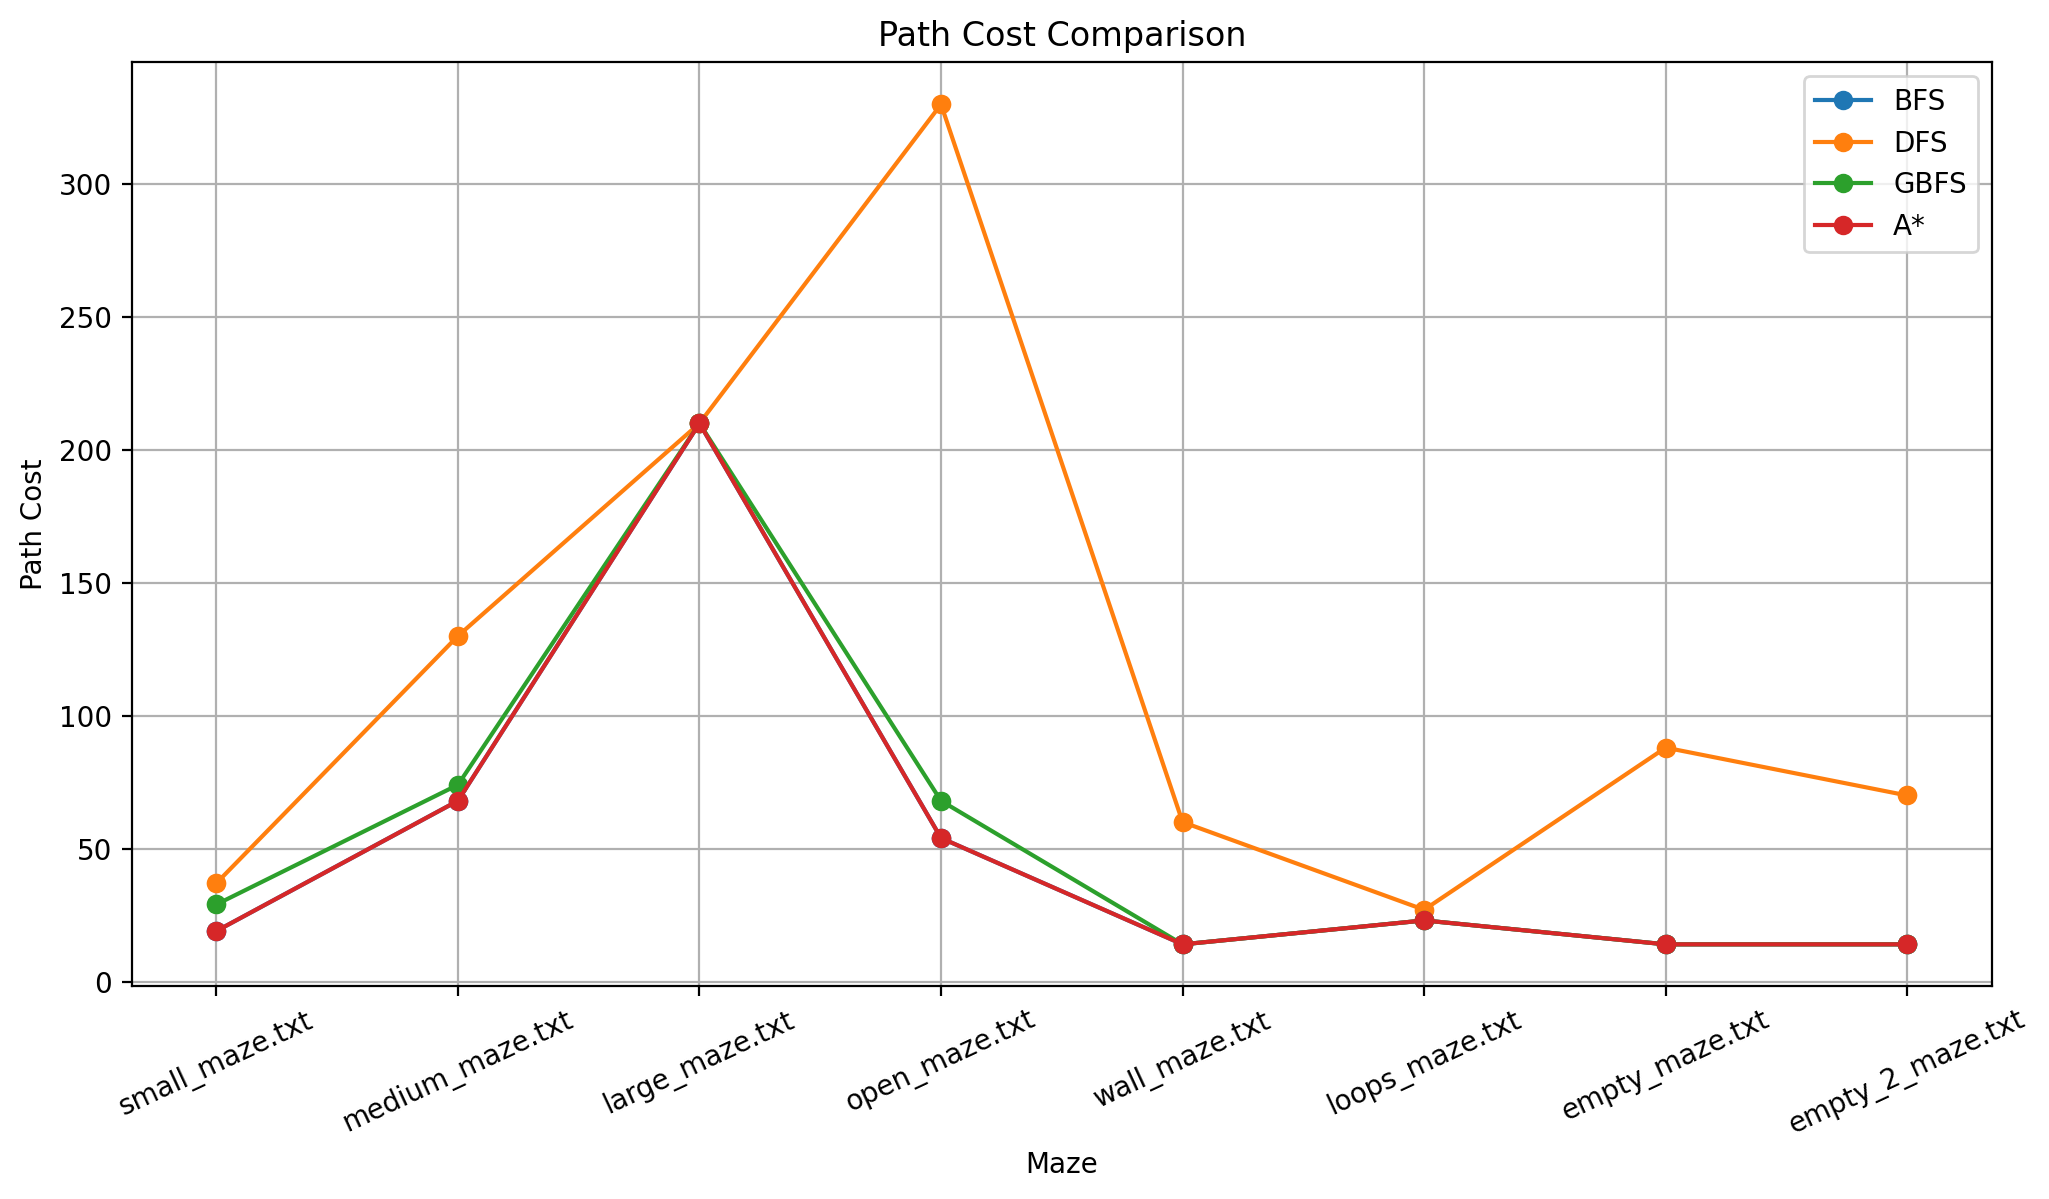

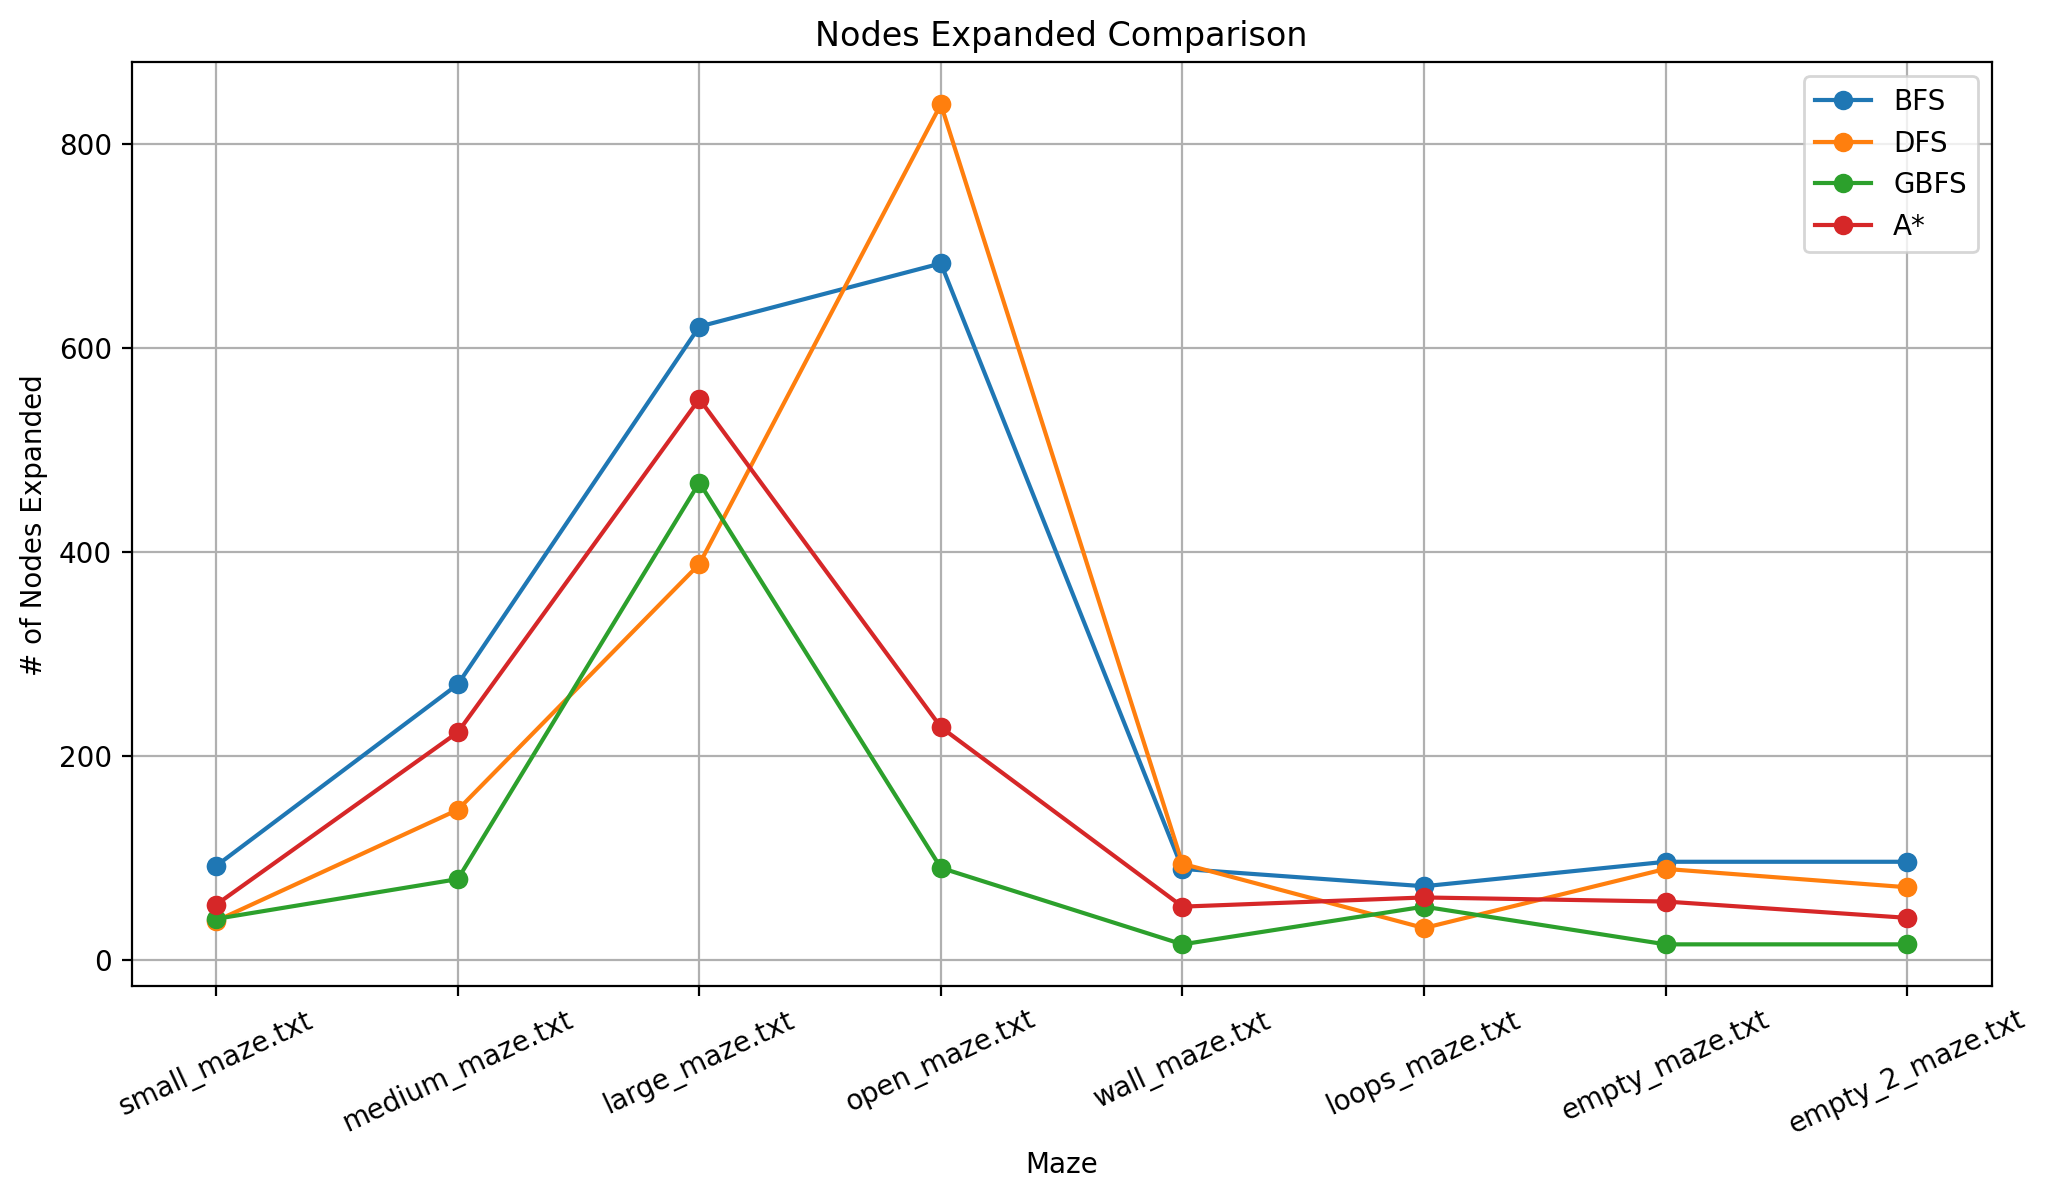

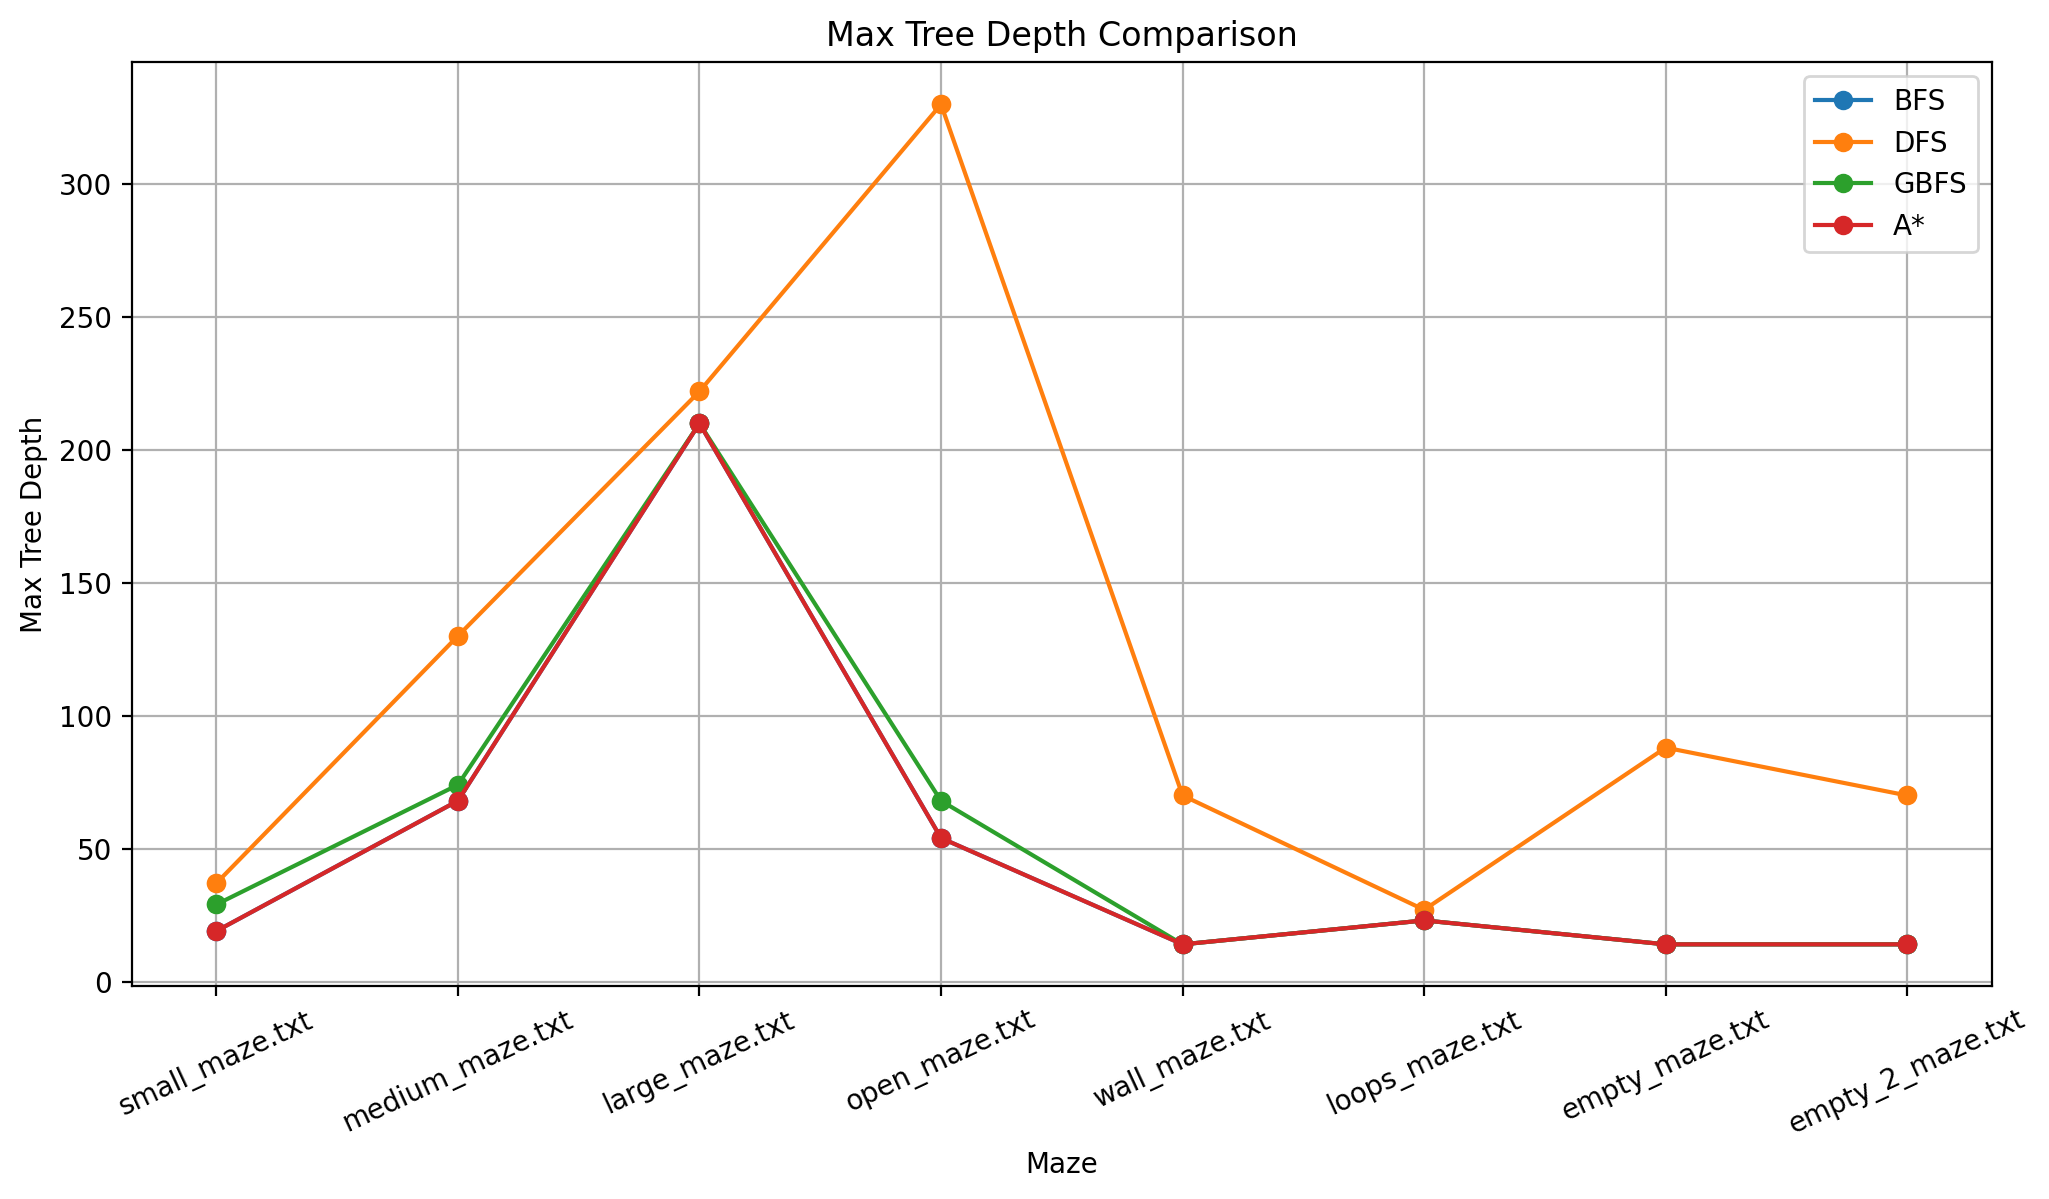

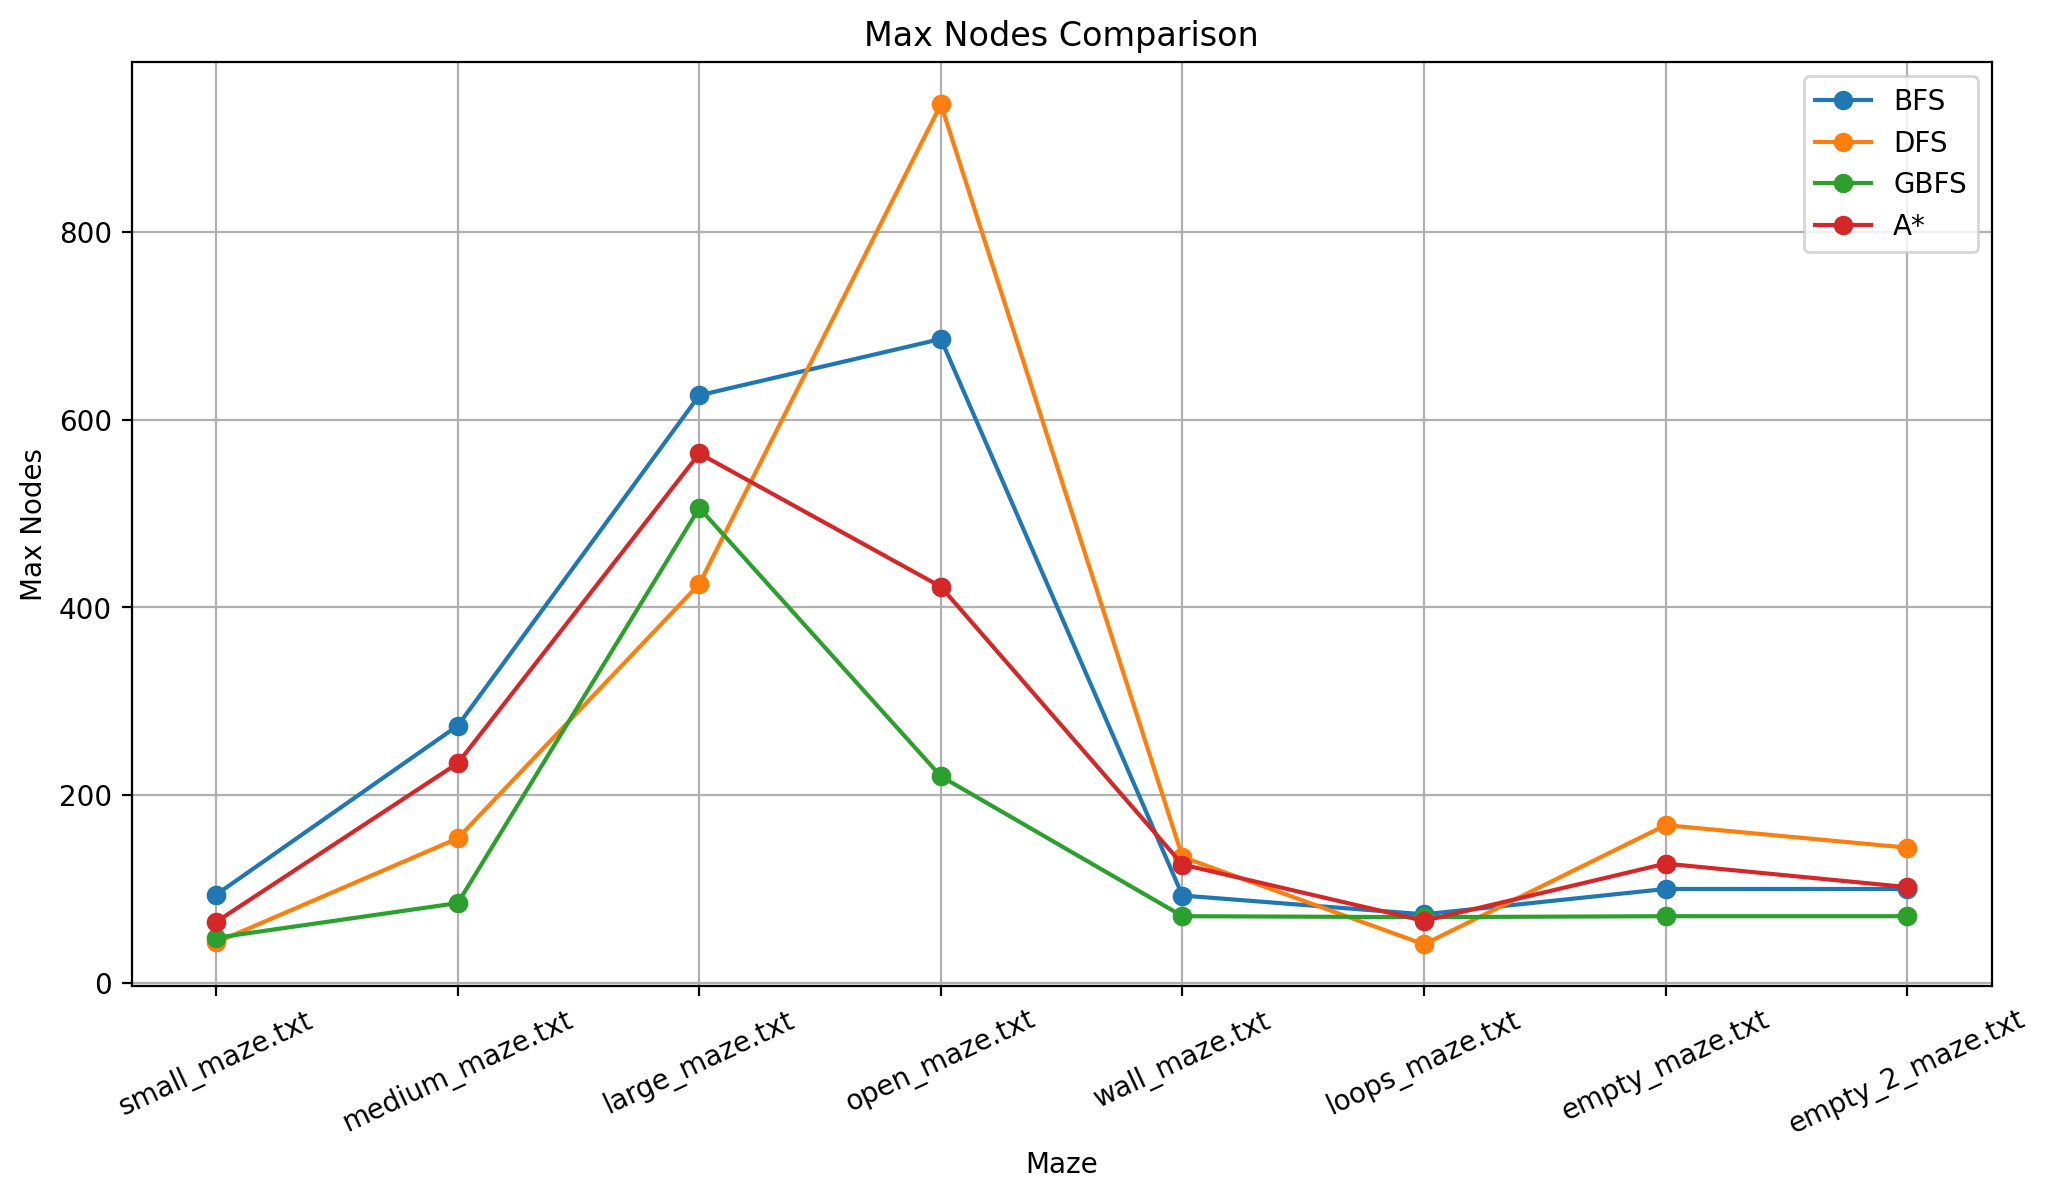

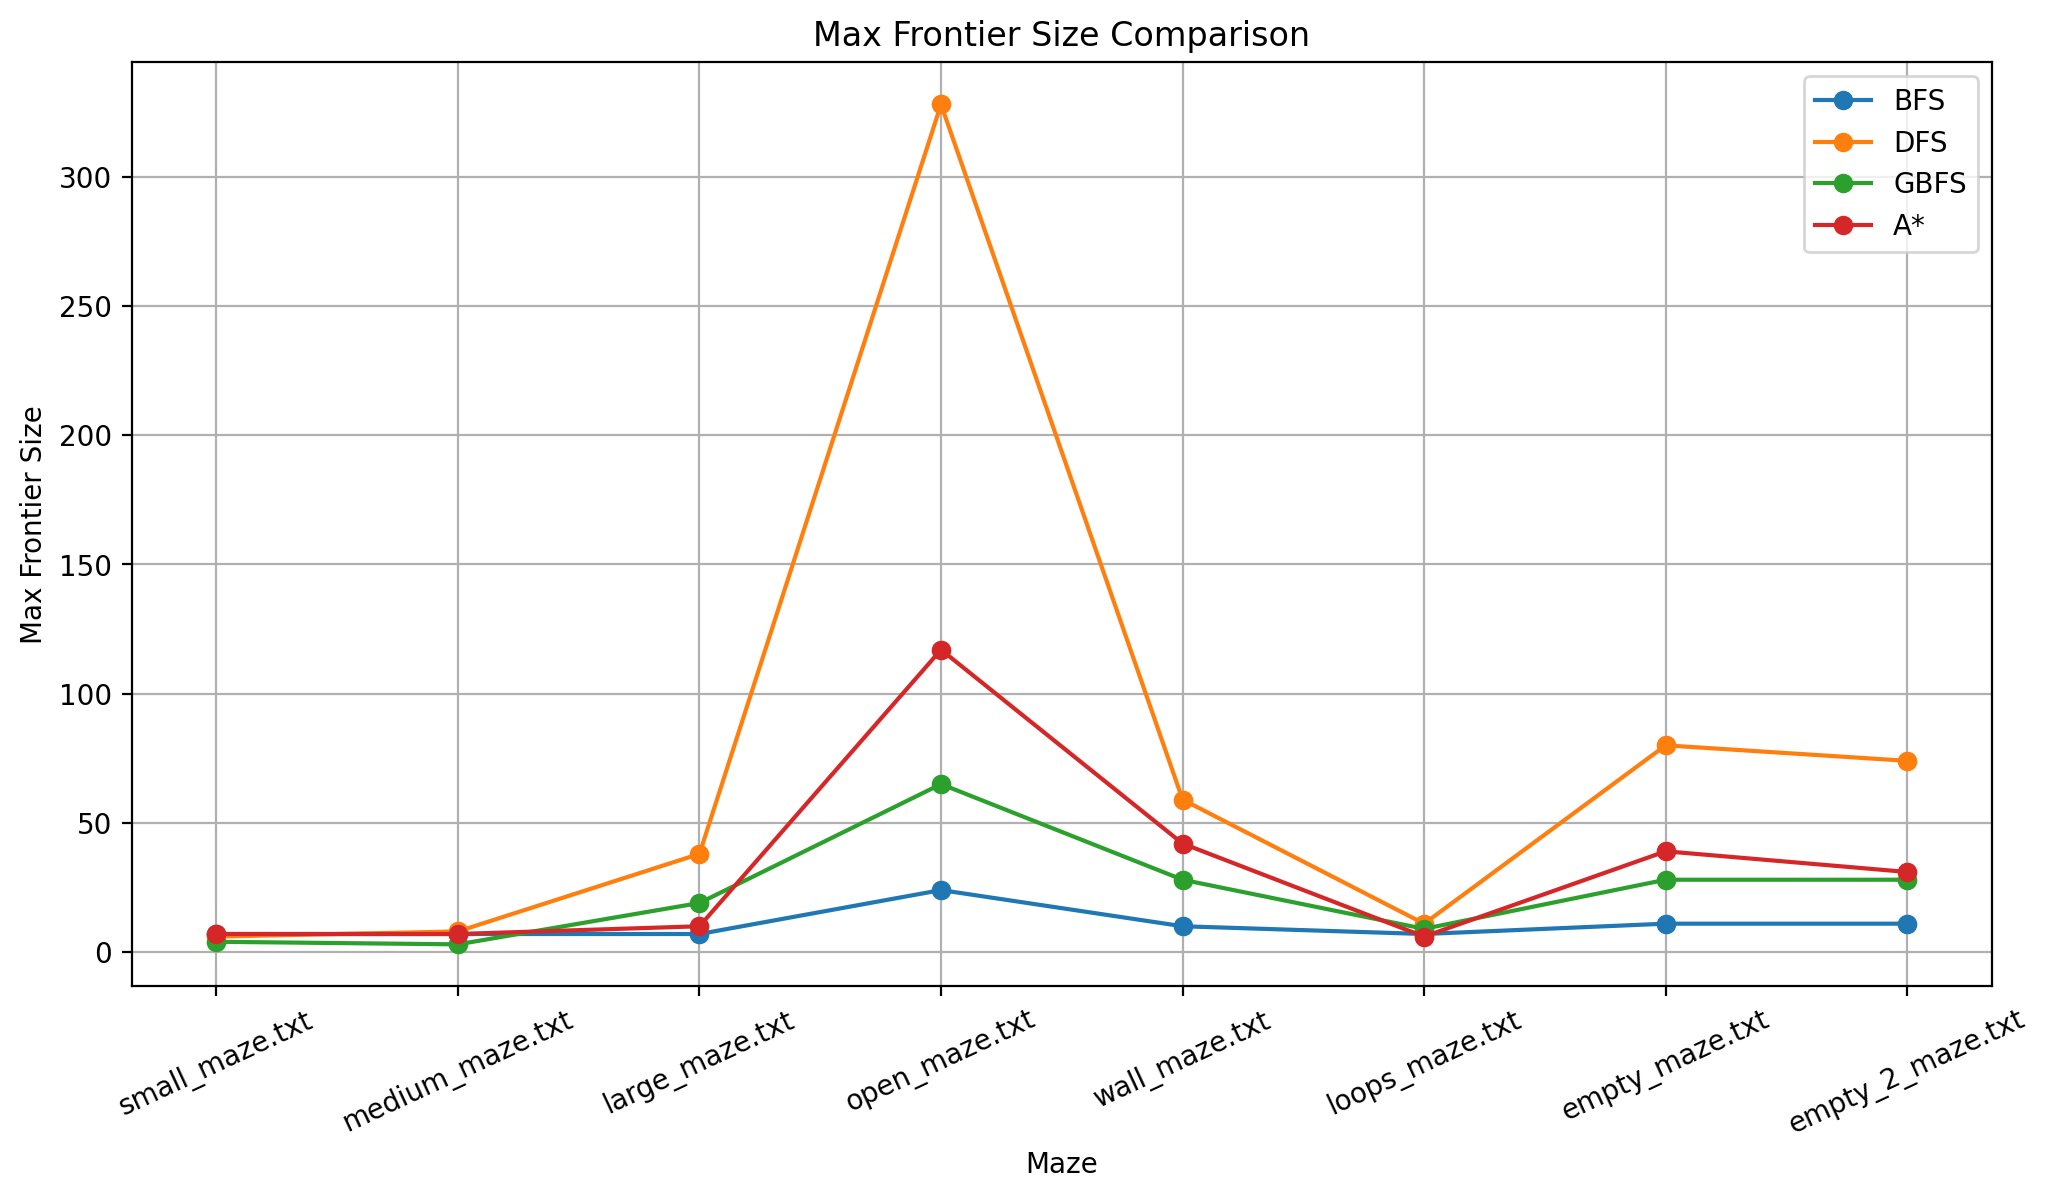

In [91]:
# Add charts
import matplotlib.pyplot as plt

def plot_comparison(metric, title, ylabel):
    plt.figure(figsize=(12, 6))

    for algo in ["BFS", "DFS", "GBFS", "A*"]:
        subset = df[df["Algorithm"] == algo]
        if not subset.empty:
            plt.plot(subset["Maze"], subset[metric], label=algo, marker="o")
            plt.scatter(subset["Maze"], subset[metric], alpha=0.7)

    plt.xlabel("Maze")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=25)
    plt.grid()
    plt.show()

# Plot comparisons
plot_comparison("Path Cost", "Path Cost Comparison", "Path Cost")
plot_comparison("Nodes Expanded", "Nodes Expanded Comparison", "# of Nodes Expanded")
plot_comparison("Max Tree Depth", "Max Tree Depth Comparison", "Max Tree Depth")
plot_comparison("Max Nodes", "Max Nodes Comparison", "Max Nodes")
plot_comparison("Max Frontier Size", "Max Frontier Size Comparison", "Max Frontier Size")

Discuss the most important lessons you have learned from implementing the different search strategies.

In [ ]:
# Add discussion
"""
The most important lessons that I learned from implementing the different search strategies is that BFS guarantees the shortest path but it is really memory intensive since it expands a large amount of
nodes. It also expands level by level, so it will always find the most optimal solution, but the memory usage will grow as the mazes get larger. The lesson I learned about DFS is that it will find the
solution but it won't find the shortest path and it is requires less memory than BFS, but unrelaible for large open spaces. If DFS did not have cycle detection then it would be stuck in an infinite loop
and DFS has a larger max depth tree because .
For Greedy Best-First Search it expands fewer nodes than BFS since it prioritizes node closer to the goal but it doesn't always guarentee the shortest path, so if the heurisitic is inaccurate then the
GBFS will perform poorly. Finally A* will always find the shortest path just like BFS and it will expand
prioritizes nodes closest to the goal
"""

---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.